# Learning Gate - Reto

## Análisis de empleados en una red de correo electrónico

### Data Science - Social Networks Analysis

## Introducción 

Actualmente es importante conocer cuáles son las estructuras sociales más propicias para transferir conocimientos y mejorar el desempeño laboral en redes de comunicación. Antes se analizaban redes de comunicación cara a cara, pero hoy en día, con el crecimiento del trabajo desde casa, esta comunicación ha sido sustituida por el correo electrónico. 

 

Hay que tener en cuenta las diferencias en estos dos tipos de redes. En las redes cara a cara, se puede relacionar la interacción entre las personas con una mayor productividad de los trabajadores, mientras que en la comunicación por correo electrónico ocurre lo contrario. En una red de comunicación de correo electrónico que una persona dedique tanto tiempo a escribir correos evita que se enfoque en lo que es su trabajo.

 
Trabajaremos con la base de datos de la empresa Enron Corporation que fue una empresa energética estadounidense de servicios, que dejó de operar en 2007:

*Esta base de datos consta de vínculos entre 143 empleados que enviaron correos electrónicos entre sí dentro del sistema. El conjunto de datos tiene un total de 623 enlaces de correo electrónico.*

Queremos que uses el análisis de redes sociales para entender cuáles son los nodos clave de la red, como es la distribución y comportamiento de la red. Los datos los encontraras en el archivo ‘email-enron-only.mtx’. El cual contiene dos columnas, el que envía el correo y quien lo recibe.

## Objetivo

El objetivo de este reto es poner en práctica los contenidos revisados durante el módulo realizando los siguientes pasos: 

- Construir una red a partir de una base de datos y lograr una visualización a adecuada de la red
- Análisis de distancias en la red
- Análisis de resiliencia
- Análisis de centralidades

## Importing Libraries and Preparing Data to be Processed

### Importing Libraries

In [1]:
import os, glob, random
import networkx as nx 
from networkx.algorithms import bipartite
import networkx.algorithms.connectivity as nxcon 
import networkx.algorithms.community as nxcom 
import pandas as pd
import numpy as np
import warnings 
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')
from io import StringIO
from scipy.io import mmread
import matplotlib.pyplot as plt

%matplotlib inline

### Loading Data

In [2]:
path = os.path.join(os.getcwd(), 'Data', 'mail-enron-only.mtx')
file2read = open(path, 'r', encoding='utf-8')
file2review = []

for line in file2read:
    file2review.append(line.strip().split())
file2read.close()

df = pd.DataFrame(file2review, columns=['Sender', 'Receiver'])

display(df.head(5))

,Sender,Receiver
0,17,1
1,72,1
2,3,2
3,19,2
4,20,2


### Defining Custom Functions

In [3]:
def NetworkCentrality(g, metric, maintititle, title1, title2, amplitude_factor=10):

    fig = plt.figure(figsize=(13,6), facecolor='lightgray')
    fig.suptitle('Visualizing Newtworks Centrality - {}'.format(maintititle))
    fig.subplots_adjust(left=0.2,wspace = 0.1)
    ax1 = plt.subplot2grid((1,3),(0,0)) 
    bbox=[0, 0, 3, 1]

    ax1.set_title(title1, fontsize=11)
    ax1.axis('off')

    measurements = dict(metric)
    table = pd.DataFrame(measurements, index=range(1)).transpose().sort_values(0, ascending=False)
    table.rename(columns={table.columns[-1]:'Centrality Measure'}, inplace=True)
    table['Node'] = table.index
    table.reset_index(drop=True, inplace=True)
    table = table.loc[:9, ['Node', 'Centrality Measure']]
    table = ax1.table(cellText=table.values, bbox=[0,0,1,.75], colLabels=table.columns, colWidths=[.45,.55])

    for (row,col), cell in table.get_celld().items():
        
        if (row == 0) & (col==0):
            cell.set_facecolor('white')
            cell.set_edgecolor('white')    
            cell.set_text_props(weight='bold', horizontalalignment='center')
        elif (row == 0) & (col==1):
            cell.set_text_props(weight='bold', horizontalalignment='right')
            cell.set_facecolor('white')
            cell.set_edgecolor('white')
        
        elif (row%2 == 0):
            if  col == 0:
                cell.set_text_props(weight='bold', horizontalalignment='center', fontsize=10)
            cell.set_edgecolor('white')
            cell.set_facecolor('white')
        elif (row%2 == 1):
            if col == 0:
                cell.set_text_props(weight='bold', horizontalalignment='center')
            cell.set_edgecolor('white')
            cell.set_facecolor('whitesmoke')  


    ax2 = plt.subplot2grid((1,3),(0,1),colspan=2) 
    ax2.set_title(title2, fontsize=11)


    deg_cen = [(k, v) for k, v in sorted(measurements.items(), key=lambda item: -item[1])]
    nx.draw_networkx(g, pos, with_labels=True, node_size=[v * amplitude_factor for v in measurements.values()],
                 ax=ax2, node_color='r', edge_color='darkturquoise', font_size=7, font_color='yellow')


def path_length_histogram(G, title=None):
  # Find path lengths
  length_source_target = dict(nx.shortest_path_length(G))
  # Convert dict of dicts to flat list
  all_shortest = sum([
                      list(length_target.values())
                      for length_target
                      in length_source_target.values()],
                     [])
  # Calculate integer bins
  high = max(all_shortest)
  bins = [-0.5 + i for i in range(high + 2)]
  # Plot histogram
  plt.hist(all_shortest, bins=bins, rwidth=0.8)
  plt.title(title)
  plt.xlabel("Distance")
  plt.ylabel("Count")


def molloy_reed(degrees):
  return (np.mean(degrees)*(np.mean(degrees)+1))/np.mean(degrees)
    
def breakdown_threshold(degrees):
  K = molloy_reed(degrees)
  return 1 - (1/(K-1))


def random_node(g): # select a random node from graph
    return [np.random.choice(g.nodes())]

def dismantle(g, function, **args): # incrementally removes node from a graph and computes size of connected components
    total_nodes = g.number_of_nodes()
    removed_nodes = []
    components = []
    while len(g.nodes()) > 1:
        n = function(g, **args)[0]
        g.remove_node(n)
        removed_nodes.append((len(removed_nodes)+1)/total_nodes)
        comps = list(nx.connected_components(g))
        g_size = 0
        if len(comps)>0:
            g_size = max([len(c)for c in comps])/total_nodes
        components.append(g_size)
    return removed_nodes, components

def get_sorted_nodes(g, score, reverse=True): # sort nodes
    nodes = score(g)
    if isinstance(nodes, dict):
        nodes = [(k, v) for k, v in nodes.items()]
    srt = sorted(nodes, key = lambda k: k[1], reverse = reverse)
    return [x[0] for x in srt]
    
def plot_dismantle(x, y, ax):
    ax.plot(x, y)
    ax.set_xlabel("Removed Nodes")
    ax.set_ylabel("Giant Component size")

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

## Exploratory Data Analysis

### Undirected Network

- ***Creating the Undirected Network Using the Loaded Data***

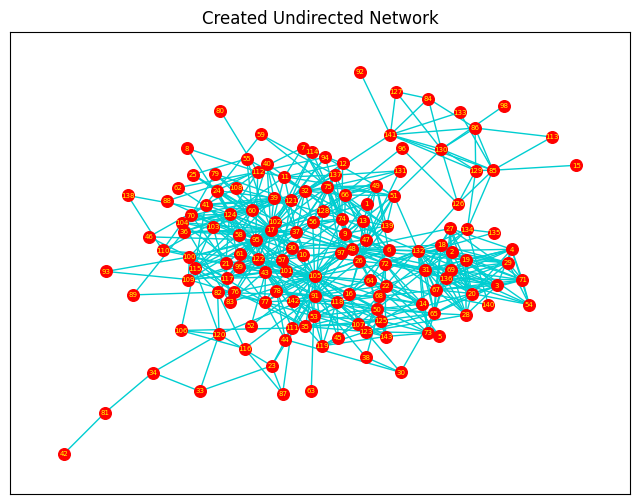

In [4]:
g = nx.Graph()
g.add_edges_from([(a[0], a[1]) for a in df.loc[:,:].values.tolist()])
fig, ax = plt.subplots(1,1 ,figsize=(8,6))
pos = nx.kamada_kawai_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=70, ax=ax, node_color='r', edge_color='darkturquoise',
                 font_size=5, font_color='yellow')
ax.set_title('Created Undirected Network');

#### Network Centrality Metrics

- ***Nodes Degrees***

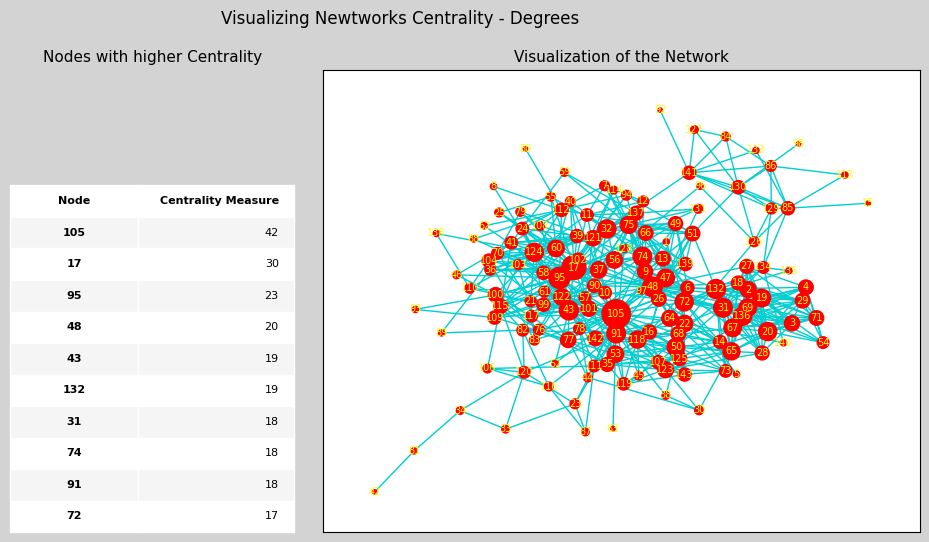

In [5]:
NetworkCentrality(g, g.degree, 'Degrees','Nodes with higher Centrality', 'Visualization of the Network')

- ***Eigenvector Centrality***

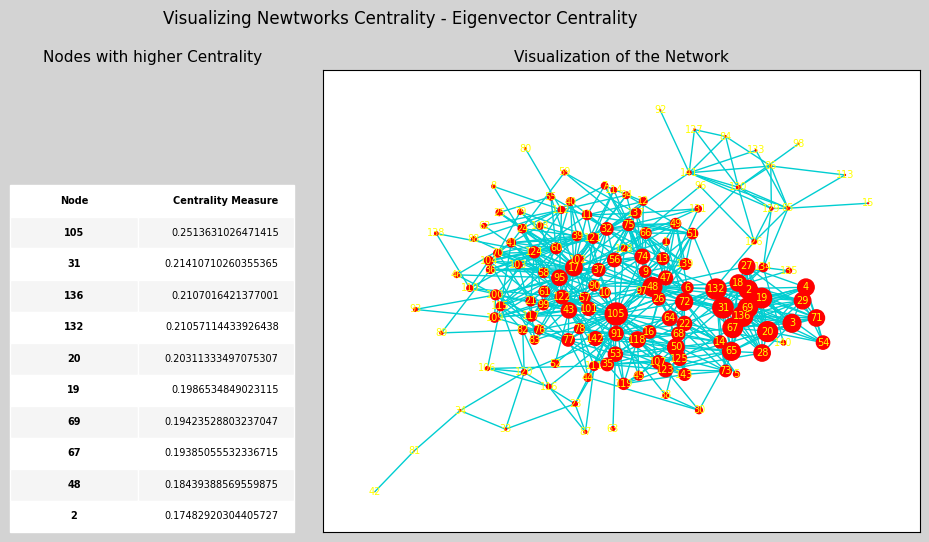

In [6]:
eigen = nx.eigenvector_centrality(g)
NetworkCentrality(g, eigen, 'Eigenvector Centrality','Nodes with higher Centrality', 
                  'Visualization of the Network', amplitude_factor=1/.001)

- ***Betweenness centrality***

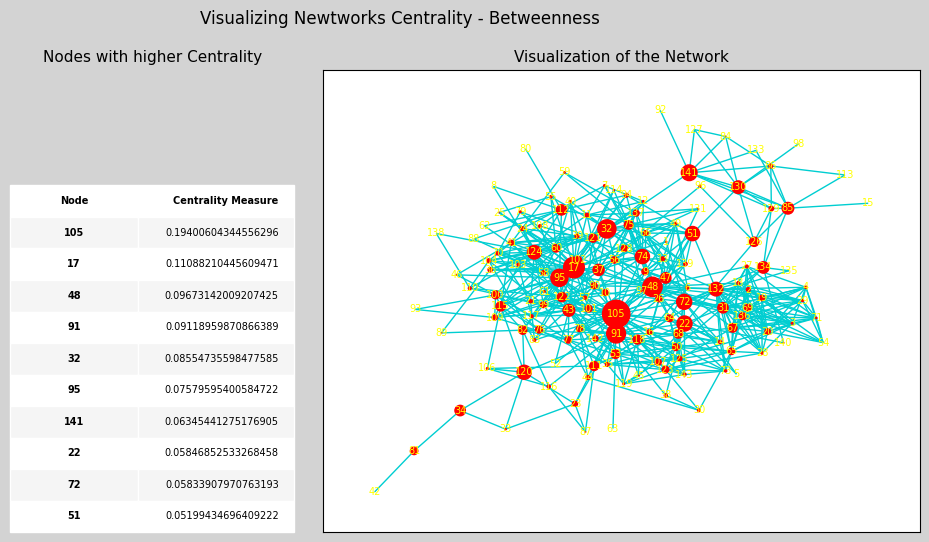

In [7]:
betweenness = nx.betweenness_centrality(g)
NetworkCentrality(g, betweenness, 'Betweenness','Nodes with higher Centrality', 
                  'Visualization of the Network', amplitude_factor=1/.0005)

- ***Closeness centrality***

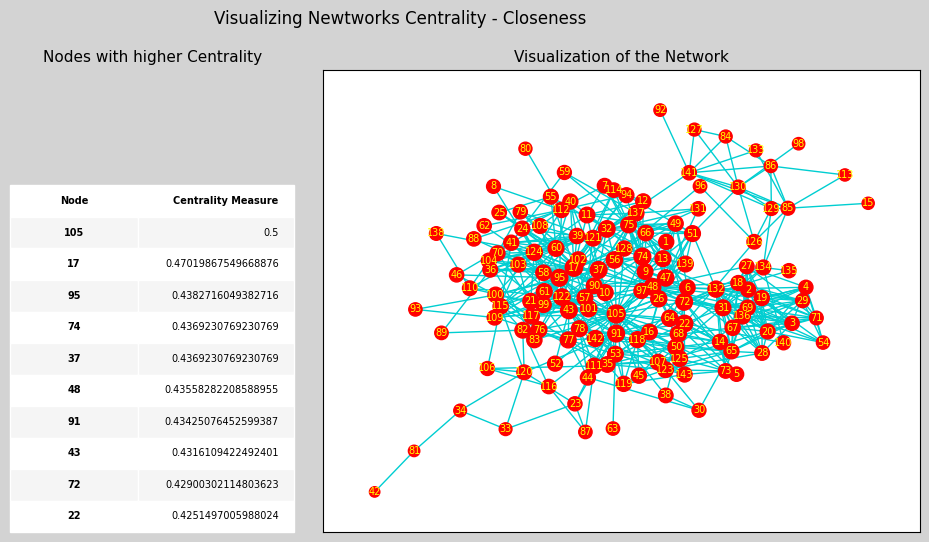

In [8]:
closeness = nx.closeness_centrality(g)
NetworkCentrality(g, closeness, 'Closeness','Nodes with higher Centrality', 
                  'Visualization of the Network', amplitude_factor=1/.003)

- ***Harmonic centrality***

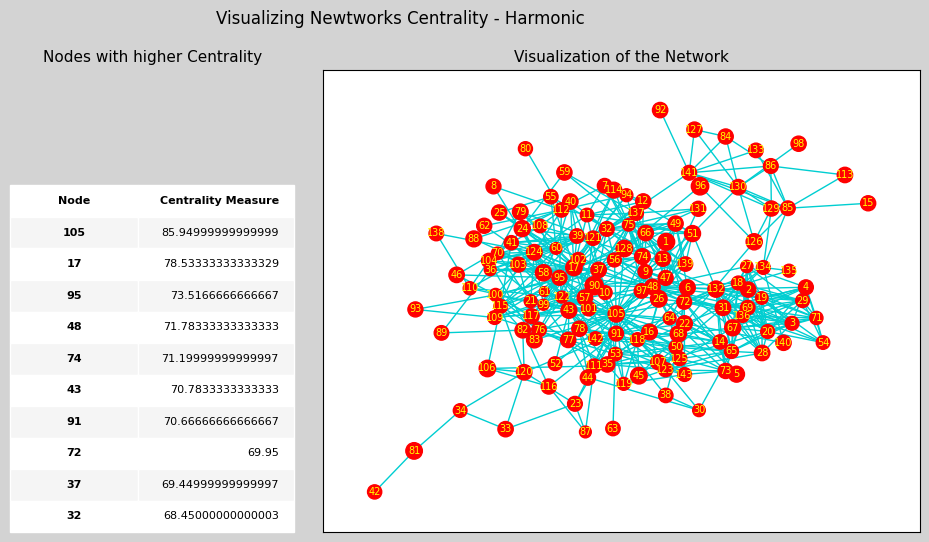

In [9]:
harmonic = nx.harmonic_centrality(g)
NetworkCentrality(g, harmonic, 'Harmonic','Nodes with higher Centrality', 
                  'Visualization of the Network', amplitude_factor=2)

#### Emails distances between Nodes

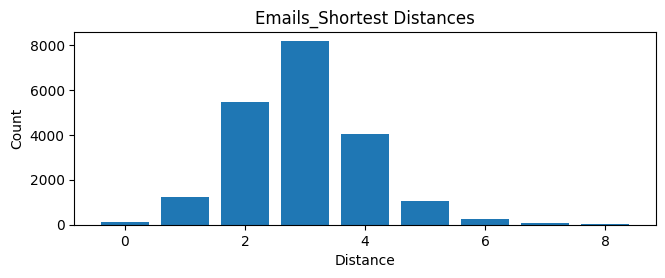

In [10]:
# Create figure
plt.figure(figsize=(7.5, 2.5))
# Plot path length histograms
path_length_histogram(g, title="Emails_Shortest Distances")

#### Summary of Metrics

In [11]:
Tipo = 'Undirected'

metrics_dic = dict({'Shorters_Avg_Dist':nx.average_shortest_path_length(g),
                    'Node_Higher_Degree':list({k: v for k, v in sorted(dict(g.degree).items(), key=lambda item: item[1], reverse=True)}.keys())[0],
                    'Node_Lower_Degree':list({k: v for k, v in sorted(dict(g.degree).items(), key=lambda item: item[1], reverse=True)}.keys())[-1],
                    'Diameter':nx.diameter(g),
                    'Nodes4Disconnection':list(nxcon.minimum_node_cut(g)),
                    'Edges4Disconnection':list(nxcon.minimum_edge_cut(g)),
                    'Avg_NodeConnectivity':nx.average_node_connectivity(g),
                    'NetworkType':Tipo})

pd.DataFrame(metrics_dic, index=['Metrics']).transpose()

,Metrics
Shorters_Avg_Dist,2.967005
Node_Higher_Degree,105
Node_Lower_Degree,98
Diameter,8
Nodes4Disconnection,85
Edges4Disconnection,"(81, 42)"
Avg_NodeConnectivity,4.951344
NetworkType,Undirected


#### Network Resilience

Text(0.5, 1.0, 'Simulating Attacks on Nodes with High Degrees')

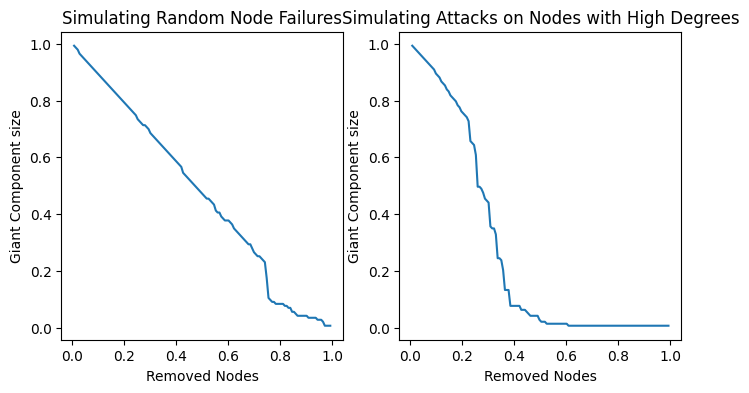

In [12]:
fig, axs = plt.subplots(1,2, figsize=(8,4))  
h = g.copy()
rn, comps = dismantle(h, random_node)
plot_dismantle(rn, comps, axs[0])
axs[0].set_title('Simulating Random Node Failures')
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.degree)
plot_dismantle(rn, comps, axs[1])
axs[1].set_title('Simulating Attacks on Nodes with High Degrees')

#### Communities within the Network

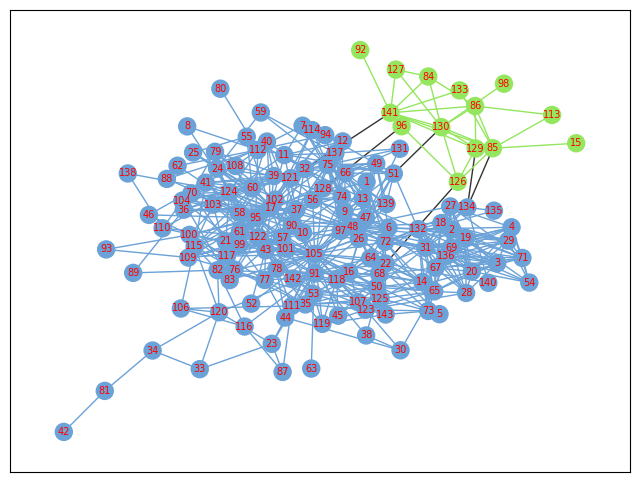

In [13]:
communities = sorted(nxcom.greedy_modularity_communities(g), key=len, reverse=True) 

result = nxcom.girvan_newman(g)
communities = next(result)
len(communities)

# Set node and edge communities
set_node_community(g, communities)
set_edge_community(g)

# Set community color for nodes
node_color = [get_color(g.nodes[v]['community']) for v in g.nodes]

# Set community color for internal edges
external = [(v, w) for v, w in g.edges if g.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g.edges if g.edges[v, w]['community'] > 0]
internal_color = [get_color(g.edges[e]['community']) for e in internal]

fig, ax = plt.subplots(1,1 ,figsize=(8,6))
pos = nx.kamada_kawai_layout(g)
#pos = nx.spring_layout(g)
# Draw external edges
nx.draw_networkx(g, pos=pos, font_size=0, font_color='yellow', node_size=0, edgelist=external, edge_color="#333333")

# Draw nodes and internal edges
nx.draw_networkx(g, pos=pos, node_size=150, font_size=7, font_color='Red', node_color=node_color, edgelist=internal,
    edge_color=internal_color)


### Directed Network

- ***Creating the Directed Network Using the Loaded Data***

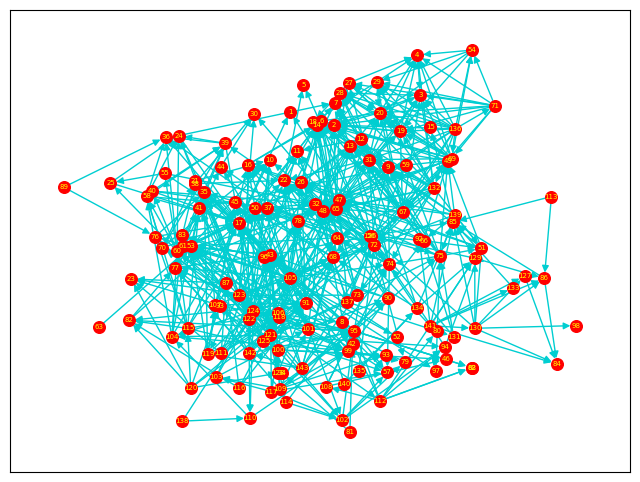

In [14]:
h = nx.DiGraph() 
h.add_edges_from([(a[0], a[1]) for a in df.loc[:,:].values.tolist()])
pos = nx.kamada_kawai_layout(h)
fig, ax = plt.subplots(1,1 ,figsize=(8,6))
nx.draw_networkx(h, pos, with_labels=True, node_size=70, ax=ax, node_color='r', edge_color='darkturquoise',
                 font_size=5, font_color='yellow')

#### Network Centrality Metrics

- ***Nodes Degrees***

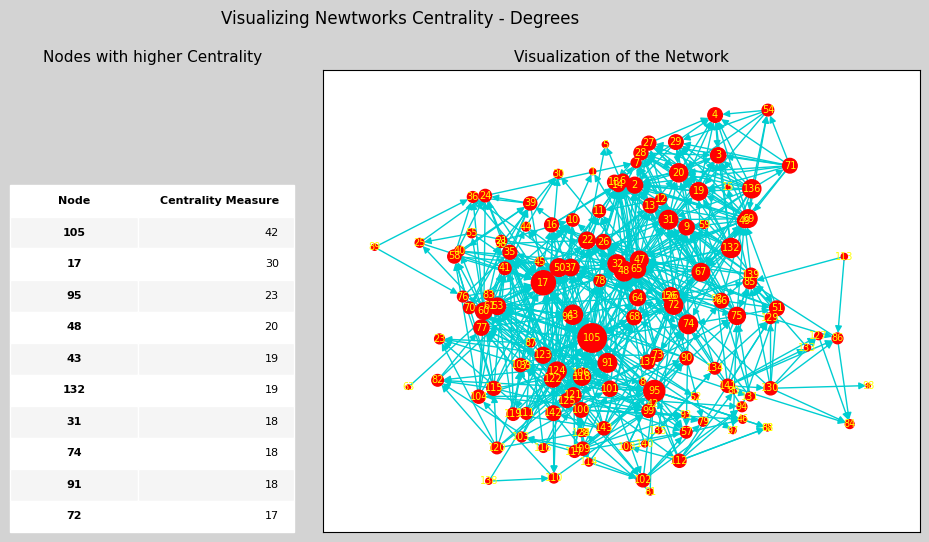

In [15]:
NetworkCentrality(h, h.degree, 'Degrees','Nodes with higher Centrality', 'Visualization of the Network')

- ***PageRank Centrality***

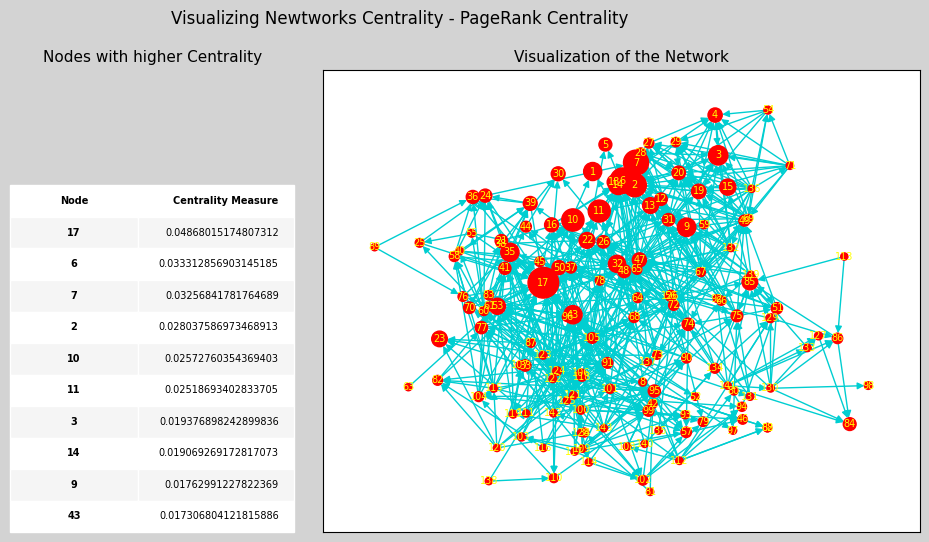

In [16]:
pagerank = nx.pagerank(h)
NetworkCentrality(h, pagerank, 'PageRank Centrality','Nodes with higher Centrality', 
                  'Visualization of the Network', amplitude_factor=1/.0001)

- ***Betweenness Centrality***

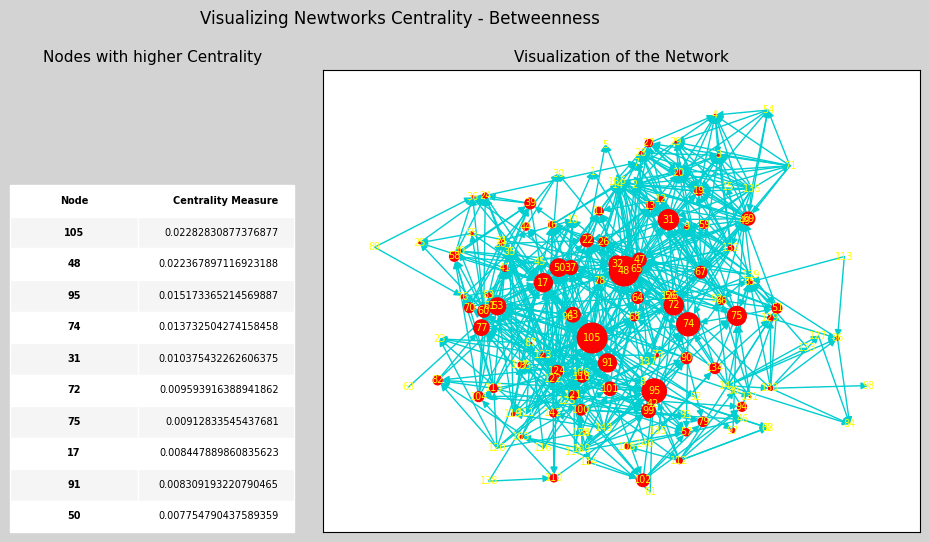

In [17]:
betweenness = nx.betweenness_centrality(h)
NetworkCentrality(h, betweenness, 'Betweenness','Nodes with higher Centrality', 
                  'Visualization of the Network', amplitude_factor=1/.00005)

- ***Closeness Centrality***

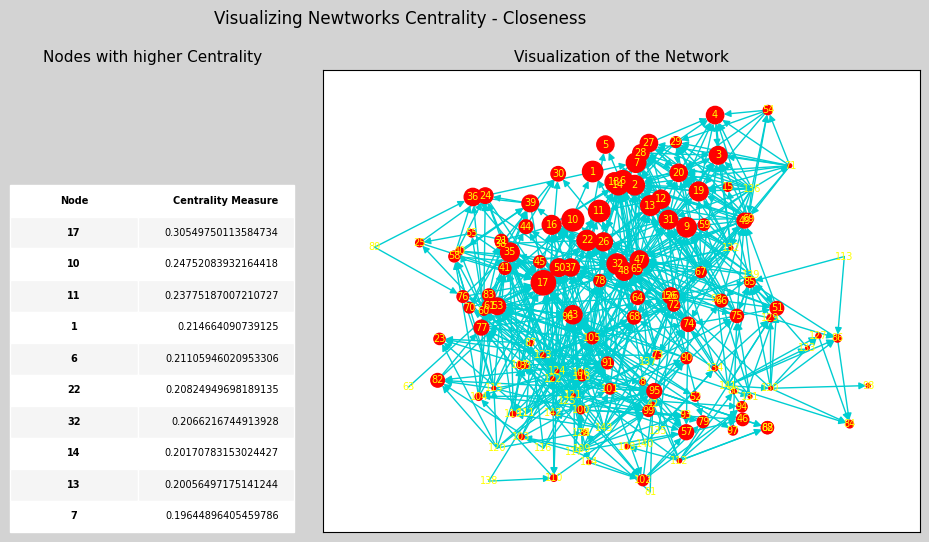

In [18]:
closeness = nx.closeness_centrality(h)
NetworkCentrality(h, closeness, 'Closeness','Nodes with higher Centrality', 
                  'Visualization of the Network', amplitude_factor=1/.001)

- ***Harmonic Centrality***

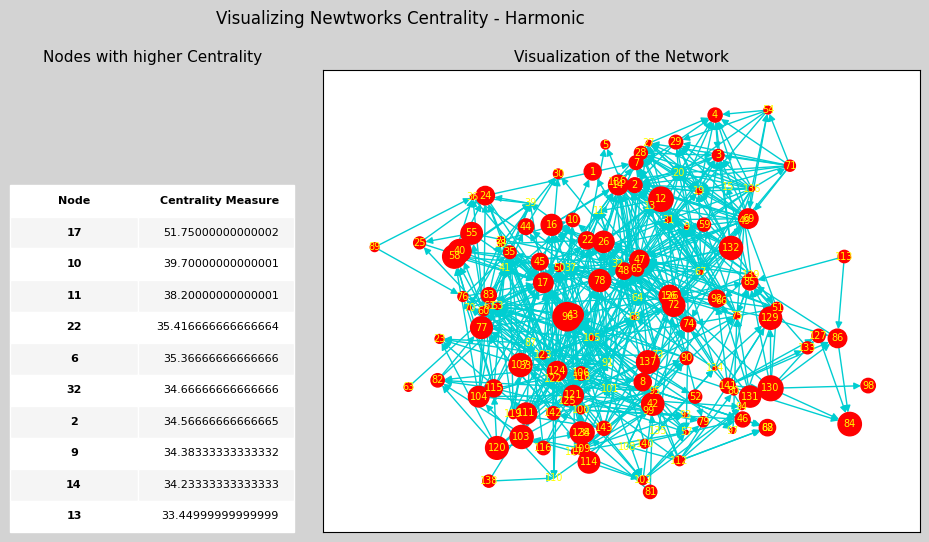

In [19]:
harmonic = nx.harmonic_centrality(h)
NetworkCentrality(h, harmonic, 'Harmonic','Nodes with higher Centrality', 
                  'Visualization of the Network', amplitude_factor=8)

#### Emails distances between Nodes

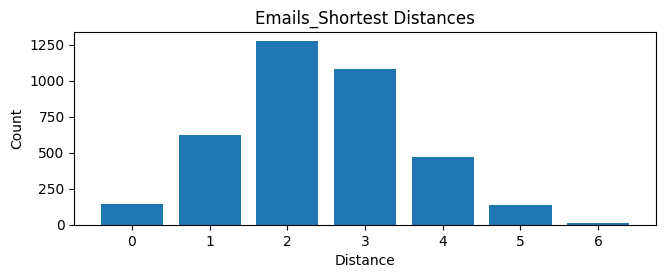

In [20]:
# Create figure
plt.figure(figsize=(7.5, 2.5))
# Plot path length histograms
path_length_histogram(h, title="Emails_Shortest Distances")

#### Summary of Metrics

In [21]:
Tipo = 'Directed'

metrics_dic = dict({'Shorters_Avg_Dist':nx.average_shortest_path_length(h.to_undirected()),
                    'Node_Higher_Degree':list({k: v for k, v in sorted(dict(h.degree).items(), key=lambda item: item[1], reverse=True)}.keys())[0],
                    'Node_Lower_Degree':list({k: v for k, v in sorted(dict(h.degree).items(), key=lambda item: item[1], reverse=True)}.keys())[-1],
                    'Diameter':nx.diameter(h.to_undirected()),
                    'Nodes4Disconnection':list(nxcon.minimum_node_cut(h.to_undirected())),
                    'Edges4Disconnection':list(nxcon.minimum_edge_cut(h.to_undirected())),
                    'Avg_NodeConnectivity':nx.average_node_connectivity(h),
                    'NetworkType':Tipo})

pd.DataFrame(metrics_dic, index=['Metrics']).transpose()

,Metrics
Shorters_Avg_Dist,2.967005
Node_Higher_Degree,105
Node_Lower_Degree,98
Diameter,8
Nodes4Disconnection,85
Edges4Disconnection,"(81, 42)"
Avg_NodeConnectivity,0.364818
NetworkType,Directed


#### Communities within the Network

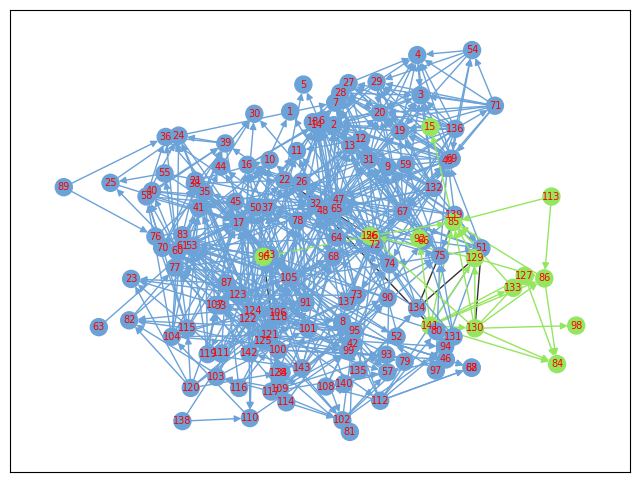

In [24]:
communities = sorted(nxcom.greedy_modularity_communities(g), key=len, reverse=True) 

result = nxcom.girvan_newman(h)
communities = next(result)
len(communities)

# Set node and edge communities
set_node_community(h, communities)
set_edge_community(h)

# Set community color for nodes
node_color = [get_color(h.nodes[v]['community']) for v in h.nodes]

# Set community color for internal edges
external = [(v, w) for v, w in h.edges if h.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in h.edges if h.edges[v, w]['community'] > 0]
internal_color = [get_color(h.edges[e]['community']) for e in internal]

fig, ax = plt.subplots(1,1 ,figsize=(8,6))
pos = nx.kamada_kawai_layout(h)
#pos = nx.spring_layout(g)
# Draw external edges
nx.draw_networkx(h, pos=pos, font_size=0, font_color='yellow', node_size=0, edgelist=external, edge_color="#333333")

# Draw nodes and internal edges
nx.draw_networkx(h, pos=pos, node_size=150, font_size=7, font_color='Red', node_color=node_color, edgelist=internal,
    edge_color=internal_color)


In [25]:
len(h.nodes)

143

In [26]:
len(h.edges)

623